metrics to compare:
- speed in ms per delta t timestep (fine solver vs end to end) -> scale that to big resolution and say we save x amount of time
- MSE, MAE for each snapshot
- generalization (marmousi and bp dataset, but then own, easier velocities)

In [1]:
from generate_data import wave_util
import torch
import numpy as np
import matplotlib.pyplot as plt
from models import model_end_to_end
from skimage.transform import resize
from models.model_utils import fetch_data_end_to_end
from generate_data.wave_propagation import velocity_verlet_tensor, pseudo_spectral, velocity_verlet
from models.model_utils import get_paths, get_params
import torch.nn.functional as F

In [6]:
#params
param_dict = get_params("0")
batch_size, lr, res_scaler, n_epochs, model_name, Nx, flipping, boundary_c, delta_t_star, f_delta_x = \
        param_dict["batch_size"], param_dict["lr"], param_dict["res_scaler"], param_dict["n_epochs"],param_dict["model_name"],param_dict["model_res"],param_dict["flipping"],param_dict["boundary_c"],param_dict["delta_t_star"],param_dict["f_delta_x"]
n_snaps = param_dict["n_snaps"]
dt = param_dict["f_delta_t"]
f_delta_t = param_dict["f_delta_t"]
dx = param_dict["f_delta_x"]
dT = param_dict["c_delta_t"]
dX = param_dict["c_delta_x"]
c_Nx = c_Ny = int(Nx) // int(res_scaler)

data_paths, train_logger_path, valid_logger_path, dir_path_save = get_paths()
loaders = fetch_data_end_to_end(data_paths, shuffle=True, batch_size=1)

param settings: batch_size: 1, lr: 0.001, res_scaler: 2, n_epochs: 500, model_name: end_to_end_unet3lvl, model_res: 128, n_snaps: 11, flipping: False, boundary_c: absorbing, total_time: 0.6, delta_t_star: 0.06, f_delta_x: 0.015625, f_delta_t: 0.00078125, c_delta_x: 0.03125, c_delta_t: 0.003125
test data points: 10


In [7]:
# set up models

# restr_model1 = model_end_to_end.Restriction_nn(param_dict = param_dict).double()
# restr_model1 = torch.nn.DataParallel(restr_model1)
# restr_model1.load_state_dict(torch.load('../results/run_2/saved_model_end_to_end_unet3lvl128_7.pt'))
#
# netlist = [
#     (r'end-to-end unet 3lvl', restr_model1),
# ]
#
# for netname,netmodl in netlist:
#     model_parameters = filter(lambda p: p.requires_grad, netmodl.parameters())
#     params = sum([np.prod(p.size()) for p in model_parameters])
#     print(netname,'number of trainable parameters', params)

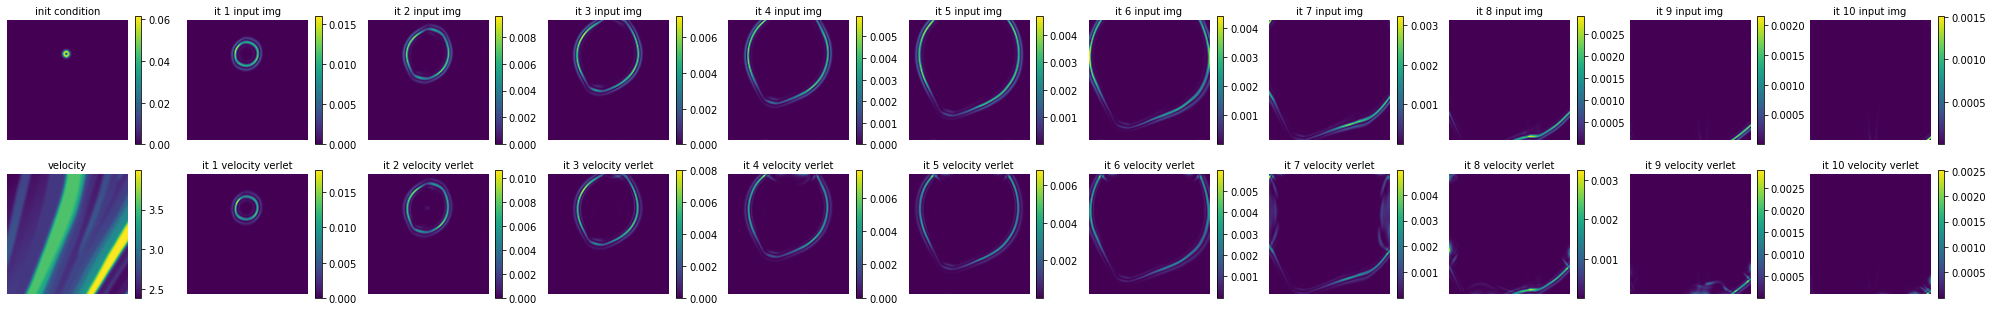

In [9]:
uc, utc = np.zeros([n_snaps-1,Nx,Nx]), np.zeros([n_snaps-1,Nx,Nx])
uf, utf = np.zeros([n_snaps-1,Nx,Nx]), np.zeros([n_snaps-1,Nx,Nx])
uo, uto = np.zeros([n_snaps-1,Nx,Nx]), np.zeros([n_snaps-1,Nx,Nx])

with torch.no_grad():
    for loader in loaders:
        for i, data in enumerate(loader):

            input = data[0].squeeze() # n_snaps x 4 x w x h
            fig = plt.figure(figsize=(35,8))

            #initial condition visualization
            u_x, u_y, u_t_c, vel = input[0, 0, :, :], input[0, 1, :, :], input[0, 2, :, :], input[0, 3, :, :]
            sumv = torch.sum(torch.sum(u_x))
            u, ut = wave_util.WaveSol_from_EnergyComponent_tensor(u_x.unsqueeze(dim=0), u_y.unsqueeze(dim=0), u_t_c.unsqueeze(dim=0), vel.unsqueeze(dim=0), f_delta_x, sumv)

            axi = fig.add_subplot(3,11,1)
            posi = axi.imshow(wave_util.WaveEnergyField_tensor(u.squeeze(),ut.squeeze(),vel,f_delta_x)*f_delta_x*f_delta_x)
            axi.set_title('init condition', fontsize=10)
            plt.colorbar(posi)
            plt.axis('off')

            # velocity visualization
            axv = fig.add_subplot(3,11,12)
            posv = axv.imshow(vel)
            plt.colorbar(posv)
            axv.set_title('velocity', fontsize=10)
            plt.axis('off')

            # fine solver iteration
            for j in range(1,input.shape[0]-1):
                u_x, u_y, u_t_c, vel_curr = input[j, 0, :, :], input[j, 1, :, :], input[j, 2, :, :], input[j, 3, :, :]  # w x h
                sumv = torch.sum(torch.sum(u_x))
                u, ut = wave_util.WaveSol_from_EnergyComponent_tensor(u_x.unsqueeze(dim=0), u_y.unsqueeze(dim=0), u_t_c.unsqueeze(dim=0), vel_curr.unsqueeze(dim=0), f_delta_x, sumv)
                uf[j-1,:,:],utf[j-1,:,:] = u.squeeze(), ut.squeeze()
                ax = fig.add_subplot(3,11,1+j)
                pos = ax.imshow(wave_util.WaveEnergyField_tensor(u.squeeze(),ut.squeeze(),vel_curr,f_delta_x)*f_delta_x*f_delta_x)
                ax.set_title('it '+str(j)+' input img', fontsize=10)
                plt.colorbar(pos)
                plt.axis('off')

            # vv
            for j in range(1,input.shape[0]-1):
                u_x, u_y, u_t_c, vel_curr = input[j-1, 0, :, :], input[j-1, 1, :, :], input[j-1, 2, :, :], input[j-1, 3, :, :]
                sumv = torch.sum(torch.sum(u_x))
                u, ut = wave_util.WaveSol_from_EnergyComponent_tensor(u_x.unsqueeze(dim=0), u_y.unsqueeze(dim=0), u_t_c.unsqueeze(dim=0), vel_curr.unsqueeze(dim=0), f_delta_x, sumv)
                ucx, utcx = velocity_verlet_tensor(u, ut, vel_curr.unsqueeze(dim=0), f_delta_x, f_delta_t, delta_t_star, number=1, boundary_c="absorbing")
                ax1 = fig.add_subplot(3,11,12+j)
                ax1.set_title('it '+str(j)+' velocity verlet', fontsize=10)
                pos1 = ax1.imshow(wave_util.WaveEnergyField_tensor(ucx.squeeze(),utcx.squeeze(),vel_curr.squeeze(),f_delta_x)*f_delta_x*f_delta_x)
                plt.colorbar(pos1)
                plt.axis('off')

            # ufx, ufcx = wave_util.WaveSol_from_EnergyComponent_tensor(input[0, 0, :, :].unsqueeze(dim=0), input[0, 1, :, :].unsqueeze(dim=0), input[0, 2, :, :].unsqueeze(dim=0), vel.unsqueeze(dim=0), f_delta_x, sumv)
            # #ufx, ufcx = ufx.numpy(), ufcx.numpy()
            # for j in range(1,input.shape[0]):
            #
            #     if j == 1: ufx, ufcx, vel = ufx.squeeze().numpy(), ufcx.squeeze().numpy(), vel.numpy()
            #
            #     ufx, ufcx = pseudo_spectral(ufx, ufcx, vel, dx, dt, delta_t_star)#, number=1, boundary_c="absorbing")#boundary_c)
            #     ax = fig.add_subplot(3,11,1+j)
            #     pos = ax.imshow(wave_util.WaveEnergyField(ufx,ufcx,vel,f_delta_x)*f_delta_x*f_delta_x)
            #     plt.colorbar(pos)
            #     plt.axis('off')
            #
            #     ufx_n, ufcx_n, vel_n = torch.from_numpy(ufx).unsqueeze(dim=0), torch.from_numpy(ufcx).unsqueeze(dim=0), torch.from_numpy(vel).unsqueeze(dim=0)
            #     ucx, utcx = velocity_verlet_tensor(ufx_n, ufcx_n, vel_n, dx, dt, delta_t_star, number=1, boundary_c="absorbing")#boundary_c)
            #     ax1 = fig.add_subplot(3,11,12+j)
            #     pos1 = ax1.imshow(wave_util.WaveEnergyField_tensor(ucx.squeeze(),utcx.squeeze(),vel_n.squeeze(),f_delta_x)*f_delta_x*f_delta_x)
            #     plt.colorbar(pos1)
            #     plt.axis('off')




            # # coarse solver
            # ucx, utcx = wave_util.WaveSol_from_EnergyComponent_tensor(input[0, 0, :, :].unsqueeze(dim=0), input[0, 1, :, :].unsqueeze(dim=0), input[0, 2, :, :].unsqueeze(dim=0), input[0, 3, :, :].unsqueeze(dim=0), dx, sumv)
            # ucx, utcx = ucx.squeeze(), utcx.squeeze()
            # for j in range(1,input.shape[0]):
            #     ucx, utcx,vel_c = torch.from_numpy(resize(ucx, [c_Nx,c_Nx], order=4)), torch.from_numpy(resize(utcx, [c_Nx,c_Nx], order=4)), torch.from_numpy(resize(vel, [c_Nx,c_Nx], order=4))
            #     ucx, utcx = velocity_verlet_tensor(
            #         ucx.unsqueeze(dim=0), utcx.unsqueeze(dim=0),
            #         vel_c.unsqueeze(dim=0), dX, dT, delta_t_star, number=1, boundary_c=boundary_c
            #     )
            #     ucx, utcx = ucx.squeeze(), utcx.squeeze()
            #     ucx, utcx = torch.from_numpy(resize(ucx, [Nx,Nx], order=4)), torch.from_numpy(resize(utcx, [Nx,Nx], order=4))
            #     uc[j-1,:,:],utc[j-1,:,:]  = ucx, utcx
            #     ax2 = fig.add_subplot(3,11,12+j)
            #     pos2 = ax2.imshow(wave_util.WaveEnergyField_tensor(ucx, utcx, vel, dx) * dx * dx)
            #     plt.colorbar(pos2)
            #     plt.axis('off')

            #end to end
            # u_x_e, u_y_e, u_t_c_e = input[0, 0, :, :].unsqueeze(dim=0), input[0, 1, :, :].unsqueeze(dim=0), input[0, 2, :, :].unsqueeze(dim=0)
            # for j in range(1,input.shape[0]):
            #     input_model = torch.stack([u_x_e, u_y_e, u_t_c_e, vel.unsqueeze(dim=0)],dim=1)
            #     output = restr_model1(input_model)  # b x 3 x w x h
            #     u_x_e, u_y_e, u_t_c_e = output[:,0, :, :].clone(), output[:,1, :, :].clone(), output[:,2, :,:].clone()
            #     sumv = torch.sum(torch.sum(u_x_e))
            #     u_e, ut_e = wave_util.WaveSol_from_EnergyComponent_tensor(u_x_e, u_y_e, u_t_c_e, vel, f_delta_x, sumv)
            #
            #     uo[j-1,:,:], uto[j-1,:,:] = u_e.squeeze(), ut_e.squeeze()
            #     ax3 = fig.add_subplot(3,11,23+j)
            #     pos3 = ax3.imshow(wave_util.WaveEnergyField_tensor(u_e.squeeze(), ut_e.squeeze(), vel, f_delta_x) * f_delta_x * f_delta_x)
            #     ax3.set_title('it ' + str(j) + ' end to end', fontsize=10)
            #     plt.colorbar(pos3)
            #     plt.axis('off')

            break
        break

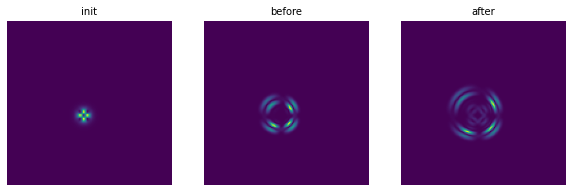

In [42]:
import random

with torch.no_grad():
    for loader in loaders:
        for i, data in enumerate(loader):
            input = data[0].squeeze() # n_snaps x 4 x w x h
            tj = 0
            u_x, u_y, u_t_c,vel = input[tj,0,:,:], input[tj,1,:,:], input[tj,2,:,:],input[tj,3,:,:]
            sumv = torch.sum(torch.sum(u_x))
            u, ut = wave_util.WaveSol_from_EnergyComponent_tensor(u_x.unsqueeze(dim=0), u_y.unsqueeze(dim=0), u_t_c.unsqueeze(dim=0), vel.unsqueeze(dim=0), f_delta_x, sumv)

            for j in random.choices(range(n_snaps-1), k=1):

                fig = plt.figure(figsize=(10,5))

                ax0 = fig.add_subplot(1,3,1)
                pos0 = ax0.imshow(wave_util.WaveEnergyField_tensor(u.squeeze(), ut.squeeze(), vel, f_delta_x))
                ax0.set_title('init', fontsize=10)
                plt.axis('off')

                # pseudo_spectral
                u, ut, vel_p = u.squeeze().numpy(), ut.squeeze().numpy(), vel.squeeze().numpy()
                p_u, p_ut = velocity_verlet(
                        u, ut,
                        vel_p, dx, dt, delta_t_star
                )
                p_u, p_ut = torch.from_numpy(p_u), torch.from_numpy(p_ut)
                ax1 = fig.add_subplot(1,3,2)
                pos1 = ax1.imshow(wave_util.WaveEnergyField_tensor(p_u.squeeze(), p_ut.squeeze(), vel, f_delta_x))
                ax1.set_title('before', fontsize=10)
                plt.axis('off')

                ucx, utcx = velocity_verlet_tensor(
                        p_u.unsqueeze(dim=0), p_ut.unsqueeze(dim=0),
                        vel.unsqueeze(dim=0), dX, dT, delta_t_star, number=1, boundary_c="periodic"
                )
                ax2 = fig.add_subplot(1,3,3)
                pos2 = ax2.imshow(wave_util.WaveEnergyField_tensor(ucx.squeeze(), utcx.squeeze(), vel, f_delta_x))
                ax2.set_title('after', fontsize=10)
                plt.axis('off')

                plt.show()
                break
            break
        break



In [ ]:
                #u_x, u_y, u_t_c,vel = input[j,0,:,:], input[j,1,:,:], input[j,2,:,:],input[j,3,:,:]
                # sumv = torch.sum(torch.sum(u_x))
                # u, ut = wave_util.WaveSol_from_EnergyComponent_tensor(u_x.unsqueeze(dim=0), u_y.unsqueeze(dim=0), u_t_c.unsqueeze(dim=0), vel.unsqueeze(dim=0), f_delta_x, sumv)
                #
                # ucx, utcx = velocity_verlet_tensor(
                #         u, ut,
                #         vel.unsqueeze(dim=0), dX, dT, delta_t_star, number=1, boundary_c="absorbing"
                # )
                #
                # fig = plt.figure(figsize=(10,5))
                # ax1 = fig.add_subplot(1,2,1)
                # pos1 = ax1.imshow(wave_util.WaveEnergyField_tensor(u.squeeze(), ut.squeeze(), vel, f_delta_x))
                # ax1.set_title('before', fontsize=10)
                # # plt.colorbar(pos1)
                # plt.axis('off')
                #
                # ax2 = fig.add_subplot(1,2,2)
                # pos2 = ax2.imshow(wave_util.WaveEnergyField_tensor(ucx.squeeze(), utcx.squeeze(), vel, f_delta_x))
                # ax2.set_title('after', fontsize=10)
                # # plt.colorbar(pos2)
                # plt.axis('off')
                # plt.show()

In [49]:
t = 3
ucx, utcx = wave_util.WaveSol_from_EnergyComponent_tensor(input[t, 0, :, :].unsqueeze(dim=0), input[t, 1, :, :].unsqueeze(dim=0), input[t, 2, :, :].unsqueeze(dim=0), vel.unsqueeze(dim=0), f_delta_x, sumv)
ucx, utcx, vel_here = ucx.unsqueeze(dim=0), utcx.unsqueeze(dim=0), vel.unsqueeze(dim=0).unsqueeze(dim=0)
print("here",ucx.unsqueeze(dim=0).shape, utcx.unsqueeze(dim=0).shape,vel.unsqueeze(dim=0).shape, dx, dt, delta_t_star)
ucx, utcx = velocity_verlet_tensor(
                    ucx.unsqueeze(dim=0), utcx.unsqueeze(dim=0),
                    vel.unsqueeze(dim=0), dx, dt, delta_t_star, number=1, boundary_c="periodic"#boundary_c
                )

here torch.Size([1, 1, 1, 128, 128]) torch.Size([1, 1, 1, 128, 128]) torch.Size([1, 128, 128]) 0.015625 0.00078125 0.06
a torch.Size([1, 1, 128, 128]) torch.Size([128, 128]) 77 1 0.015625 <class 'torch.Tensor'> torch.Size([1, 1, 128, 128])


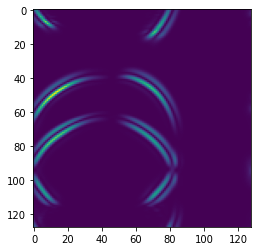

In [50]:
plt.imshow(wave_util.WaveEnergyField_tensor(ucx.squeeze(), utcx.squeeze(), vel, f_delta_x))
plt.show()

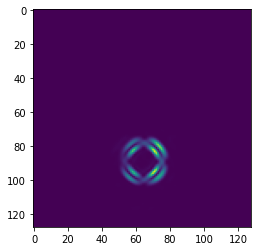

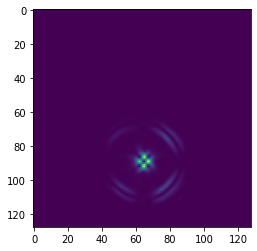

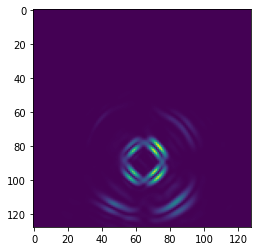

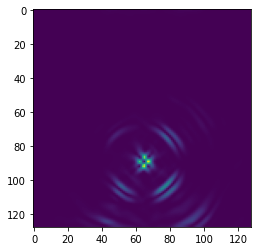

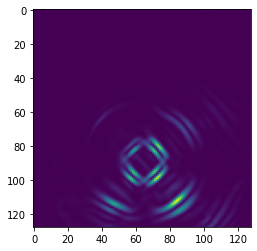

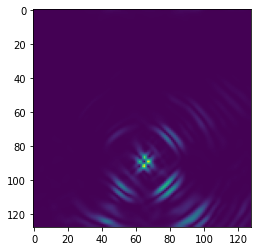

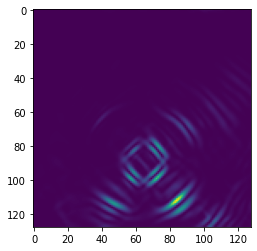

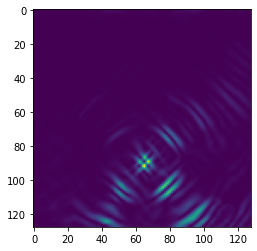

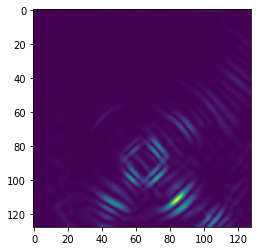

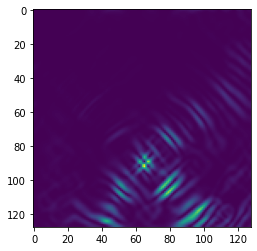

compare fine solver result to implementation:
╒════════════╤══════════════╤══════════════════╤══════════════╤══════════════════╕
│   snapshot │   MSE coarse │   MSE end to end │   MAE coarse │   MAE end to end │
╞════════════╪══════════════╪══════════════════╪══════════════╪══════════════════╡
│          0 │  1.57922e-07 │      1.36396e-08 │  4.06065e-05 │      1.66706e-05 │
├────────────┼──────────────┼──────────────────┼──────────────┼──────────────────┤
│          1 │  1.13391e-07 │      4.12618e-08 │  5.8608e-05  │      4.2658e-05  │
├────────────┼──────────────┼──────────────────┼──────────────┼──────────────────┤
│          2 │  7.21983e-08 │      2.6387e-08  │  6.72576e-05 │      4.29185e-05 │
├────────────┼──────────────┼──────────────────┼──────────────┼──────────────────┤
│          3 │  5.24044e-08 │      2.51583e-08 │  7.04133e-05 │      4.19563e-05 │
├────────────┼──────────────┼──────────────────┼──────────────┼──────────────────┤
│          4 │  3.80051e-08 │      2.5631

In [48]:
# compare wave energy norm errors:

from sklearn.metrics import mean_squared_error, mean_absolute_error
from tabulate import tabulate

table = [["snapshot", "MSE coarse", "MSE end to end", "MAE coarse", "MAE end to end"]]

for it in range(0,10):
    wf = wave_util.WaveEnergyField(uf[it,:,:], utf[it,:,:], vel.numpy(), f_delta_x)*f_delta_x*f_delta_x
    w1 = wave_util.WaveEnergyField(uc[it,:,:], utc[it,:,:], vel.numpy(), f_delta_x)*f_delta_x*f_delta_x
    w2 = wave_util.WaveEnergyField(uo[it,:,:], uto[it,:,:], vel.numpy(), f_delta_x)*f_delta_x*f_delta_x

    mse1 = mean_squared_error(wf, w1)
    mse2 = mean_squared_error(wf, w2)

    mae1 = mean_absolute_error(wf, w1)
    mae2 = mean_absolute_error(wf, w2)

    table.append([it, mse1, mse2, mae1,mae2])

print("compare fine solver result to implementation:")
print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))